In [2]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, make_scorer, precision_score
from sklearn import metrics
import os
import json
from werkzeug.utils import secure_filename
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2


### 1. Definir función de características:

In [3]:
def histograma_lab(filename, bins = 8, mask=None):
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # Convierte la imagen a espacio L*a*b*.
    histogram = cv2.calcHist([img], [0, 1, 2], mask, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    histogram = cv2.normalize(histogram, histogram).flatten()
    return histogram

In [29]:
def histograma_rgb(filename, bins = 8, mask=None):
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convierte la imagen a espacio RGB
    histogram = cv2.calcHist([img], [0, 1, 2], mask, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    histogram = cv2.normalize(histogram, histogram).flatten()
    return histogram

In [7]:
def histograma_rgb2(img_path, bins=255):
    img = cv2.imread(img_path)
    
    red, _ = np.histogram(img[:,:,0], bins)
    green, _ = np.histogram(img[:,:,1], bins)
    blue, _  = np.histogram(img[:,:,2], bins)
    
    hist = np.array([red, green, blue])
    return hist

### 2. Calcular característica para todo dataset:

In [30]:
d = []

for i in range(0, 1000):
    if os.path.isfile(os.path.join('static', str(i) + '.jpg')):
        path = os.path.join('static', str(i) + '.jpg')
        # hist = histograma_lab(path, 8) ## CAMBIAR FUNCIÓN CARACTERÍSTICAS
        hist = histograma_rgb(path, 8) ## CAMBIAR FUNCIÓN CARACTERÍSTICAS
        d.append(hist)


In [31]:
# comprobar que sale 1000

len(d)

1000

In [32]:
feature_dim = d[0].shape  # Obtiene las dimensiones de una muestra de características
print(f"Dimensiones de las características extraídas: {feature_dim}")

Dimensiones de las características extraídas: (512,)


In [10]:
feature_dim = d[0].shape  # Obtiene las dimensiones de una muestra de características
print(f"Dimensiones de las características extraídas: {feature_dim}")


Dimensiones de las características extraídas: (3, 255)


### 3. Generar df: 

INFO: hay 10 clases (las del vector 'clases'). las 100 primeras imags (0.jpg - 99.jpg) corresponden a la clase 'indigena', las 100 siguientes (100.jpg - 199.jpg) a la clase playa, ... y así.

In [33]:
df = pd.DataFrame(d)

clases = ['indigena', 'playa', 'monumento', 'autobus', 'dinosaurio', 'elefante', 'rosa', 'caballo', 'montaña', 'comida']
labels = []

for c in clases: 
    labels += [c]*100

df['class'] = labels

In [34]:
# comprobar que se ha añadido columna class:

df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,class
0,0.212775,0.002249,0.0,0.0,0.0,0.0,0.0,0.0,0.013369,0.021490,...,0.000812,0.0,0.000000,0.000000,0.005310,0.003748,0.002499,0.013806,0.002499,indigena
1,0.510023,0.095521,0.0,0.0,0.0,0.0,0.0,0.0,0.000058,0.007729,...,0.002769,0.0,0.000058,0.002134,0.001557,0.000750,0.000981,0.003461,0.005480,indigena
2,0.575064,0.002353,0.0,0.0,0.0,0.0,0.0,0.0,0.002833,0.000432,...,0.001632,0.0,0.000000,0.000000,0.000000,0.000096,0.014500,0.068180,0.078215,indigena
3,0.358378,0.000725,0.0,0.0,0.0,0.0,0.0,0.0,0.000290,0.000000,...,0.000290,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.090247,0.076906,indigena
4,0.618943,0.000277,0.0,0.0,0.0,0.0,0.0,0.0,0.184760,0.001030,...,0.000119,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.225664,0.038092,indigena


### 4. Entrenar y evaluar modelo KNN:

In [35]:
X_train = df.iloc[:,0:len(d[0])]
y_train = df['class']

In [36]:
X_train.shape

(1000, 512)

In [37]:
knn = neighbors.KNeighborsClassifier(n_neighbors=2, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=2)

In [21]:
clases = ['indigena', 'playa', 'monumento', 'autobus', 'dinosaurio', 'elefante', 'rosa', 'caballo', 'montaña', 'comida']
d = {}

t=0
for c in clases: 
        df2 = df[df['class']==c]
        prec_media = 0
        for i in df2.index:
                prec_ej = 0
                hist = np.array(df.iloc[i, :-1])
                vs = knn.kneighbors(hist.reshape(1, -1), 10)[1].tolist()[0]
                for j in vs: 
                        if c == df.iloc[j]['class']:
                                prec_ej += 1
                prec_media += prec_ej/len(vs)
        t += prec_media/100
        d[c] = prec_media/100
d


{'indigena': 0.25899999999999995,
 'playa': 0.4359999999999999,
 'monumento': 0.6289999999999998,
 'autobus': 0.9050000000000001,
 'dinosaurio': 0.954,
 'elefante': 0.8669999999999999,
 'rosa': 0.9890000000000001,
 'caballo': 0.8769999999999999,
 'montaña': 0.929,
 'comida': 0.17099999999999985}

In [22]:
t/len(clases)

0.7016

### 5. Visualizar resultados para una imagen de entrada

In [38]:
def plot_c(filename):
    h = histograma_rgb(filename, 8) ## CAMBIAR FUNCIÓN CARACTERÍSTICAS
    vs = knn.kneighbors(h.reshape(1, -1), 10)[1].tolist()[0]

    plt.figure(figsize=(20, 10))
    i = 1
    for v in vs: 
        path = os.path.join('static', str(v) + '.jpg')
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,10,i)
        plt.imshow(img)
        i += 1

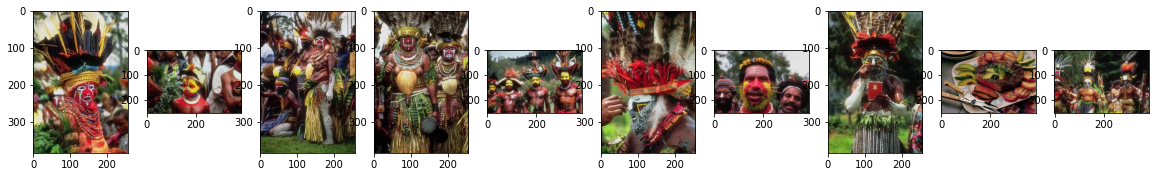

In [39]:
filename = 'static/80.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)


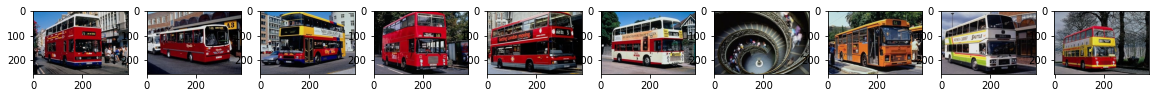

In [40]:
filename = 'static/302.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

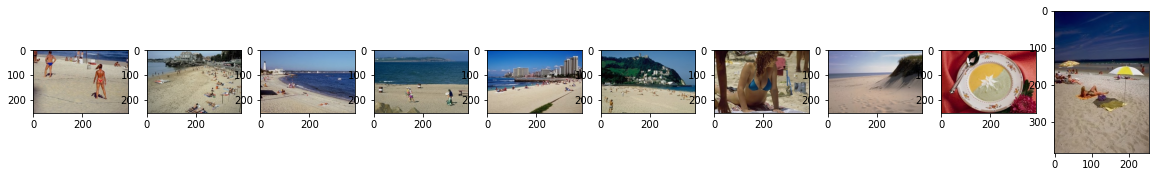

In [41]:
filename = 'static/123.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

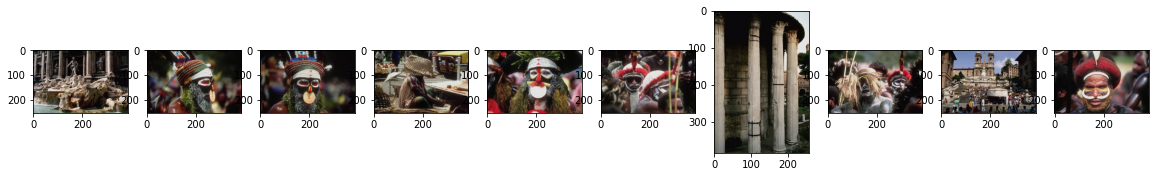

In [42]:
filename = 'static/269.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

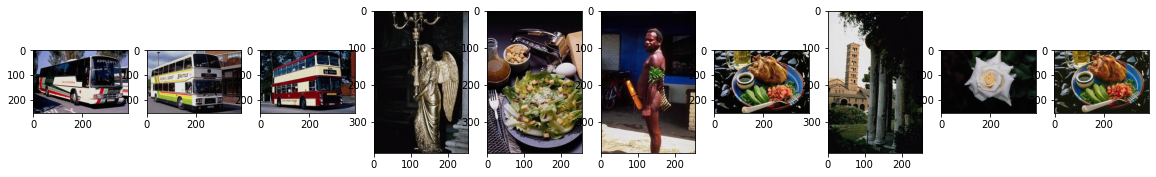

In [43]:
filename = 'static/351.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

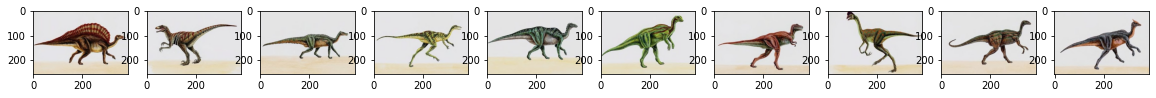

In [44]:
filename = 'static/475.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

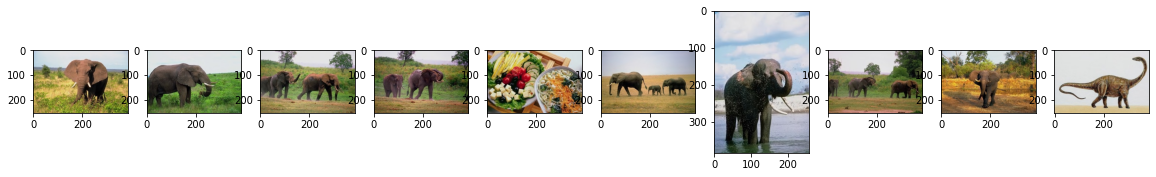

In [45]:
filename = 'static/508.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

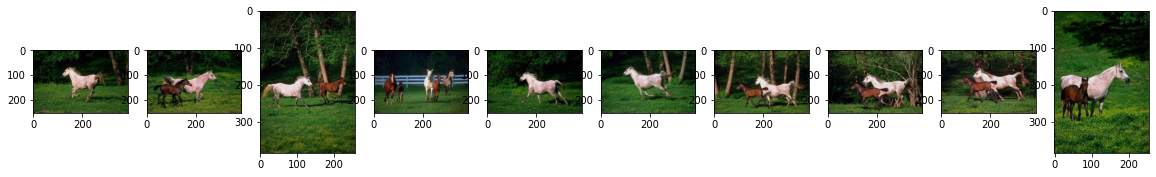

In [46]:
filename = 'static/784.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

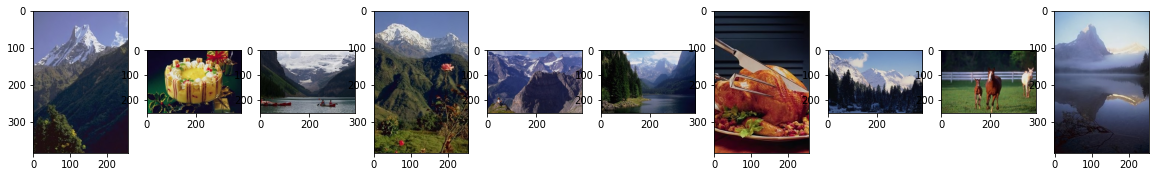

In [47]:
filename = 'static/842.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)

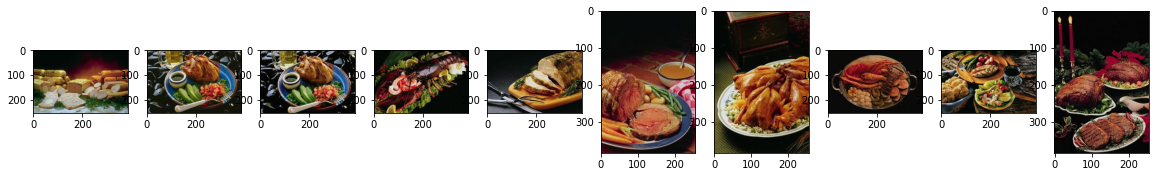

In [48]:
filename = 'static/902.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)